# Import Libraries

In [72]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Define Dataset

In [75]:
df = pd.read_csv("breast-cancer_cleaned.csv")
df

,texture_mean,symmetry_mean,fractal_dimension_mean,texture_se,area_se,smoothness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,smoothness_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,-2.073335,2.217515,2.255747,-0.565265,-0.321821,-0.214002,0.724026,0.660820,1.148757,0.907083,1.307686,1.139636,1.937015,1
1,-0.353632,0.001392,-0.868652,-0.876244,0.742402,-0.605351,-0.440780,0.260162,-0.805450,-0.099444,-0.375612,-0.243890,0.281190,1
2,0.456187,0.939685,-0.398008,-0.780083,0.557852,-0.297005,0.213076,1.424827,0.237036,0.293559,0.527407,1.152255,0.201391,1
3,0.253732,0.155462,0.046836,-0.110409,-0.288378,0.689702,0.819518,1.115007,-0.069777,0.267687,0.749217,-0.115114,0.230872,1
4,-1.151816,-0.009560,-0.562450,-0.790244,0.156716,1.483067,0.828471,1.144205,-0.361092,0.499328,0.220556,-0.868353,-0.397100,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,0.721473,-0.312589,-0.931027,0.071025,0.350640,1.086384,0.666001,2.067178,-1.138416,0.167980,0.378365,-1.360158,-0.709091,1
565,2.085134,-0.217664,-1.058611,0.322856,-0.131594,-0.424010,0.252202,0.808431,-0.189161,-0.490556,-0.691230,-0.531855,-0.973978,1
566,2.045574,-0.809117,-0.895587,-0.257371,0.180698,-0.379342,0.510827,0.612157,-0.891416,0.036727,-0.809587,-1.104549,-0.318409,1
567,2.336457,2.137194,1.043695,0.686088,0.183955,-0.173000,1.302285,0.785721,0.326634,0.904057,1.430427,1.919083,0.936537,1


In [77]:
df.columns

Index(['texture_mean', 'symmetry_mean', 'fractal_dimension_mean', 'texture_se',
       'area_se', 'smoothness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se', 'smoothness_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis'],
      dtype='object')

# Training Classifiers

### Evaluation function

In [3]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Performance:\n")
        
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Manual calc for specificity

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Error Rate: {(1-accuracy) * 100:.2f}%")
    print(f"Sensitivity (Recall): {recall * 100:.2f}%")
    print(f"Specificity: {specificity * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")

    print('\nClassification Report:\n', classification_report(y_true, y_pred))

    print('Confusion Matrix:')
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.unique(y_true))
    disp.plot(cmap='Blues', values_format=".2f")  # Display values with 2 decimal places
    plt.title(f"Confusion Matrix for {model_name} (Percentage)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Function to plot hyperparameters vs accuracy

In [4]:
def plot_hyperparameter_results(grid_search, model_name):
    # Extract results
    results = grid_search.cv_results_

    # Get mean training and validation scores
    mean_train_scores = results['mean_train_score']  # Training accuracy
    mean_val_scores = results['mean_test_score']    # Validation accuracy
    param_combinations = results['params']          # Hyperparameter combinations

    # Plot training and validation accuracy
    indices = np.arange(len(param_combinations))
    plt.figure(figsize=(20, 7))
    plt.plot(indices, mean_train_scores, marker='o', linestyle='-', color='blue', label='Training Accuracy')
    plt.plot(indices, mean_val_scores, marker='o', linestyle='--', color='orange', label='Validation Accuracy')

    # Add labels, legend, and grid
    plt.xlabel('Hyperparameter Configuration Index')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy vs. Hyperparameter Configuration ({model_name})')
    plt.xticks(indices, labels=indices)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    # Print the configurations and their scores
    for i, params in enumerate(param_combinations):
        print()
        print(f"Configuration {i}: {params}")
        print(f"   Training Accuracy: {mean_train_scores[i]:.4f}", f"\t\t   Validation Accuracy: {mean_val_scores[i]:.4f}")


### Split data into train - test sets

In [5]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Split data into training (80%), testing (20%)

The training set will be splited into train - val to get best hyperparameters using cross validation.

## Decision Tree Classifier

### Training

#### Intialize model

In [6]:
# Initialize the Decision Tree model with a fixed random seed for reproducibility
dt_model = DecisionTreeClassifier(random_state=42)

#### Get best hyperparameters using grid search

In [7]:
# Hyperparameter grid for tuning the Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],     # Use both Gini impurity and entropy for splitting nodes
    'max_depth': [3, 4],               # Test different maximum depths of the tree
    'min_samples_split': [30, 35],        # Minimum samples required to split an internal node
    'min_samples_leaf': [5, 10, 15],      # Minimum samples required to be at a leaf node
    'ccp_alpha': [0.02],            # Pruning parameter to control overfitting
    'max_features': [None, 'sqrt', 'log2']          # Added max features
}

In [8]:
# Set up GridSearchCV to tune hyperparameters with 5-fold cross-validation
dt_grid_search = GridSearchCV(
    estimator=dt_model,                 # Decision Tree model
    param_grid=dt_param_grid,           # Hyperparameter grid for tuning
    scoring='accuracy',                 # Evaluate model based on accuracy score
    cv=5,                               # 5-fold cross-validation
    return_train_score=True,            # Return training scores
    n_jobs=-1,                          # Use all CPU cores for parallel processing
    verbose=2                           # Display progress during the search
)

#### Fit model to get best hyperparameters

In [9]:
dt_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'ccp_alpha': [0.02], 'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [30, 35]},
             return_train_score=True, scoring='accuracy', verbose=2)

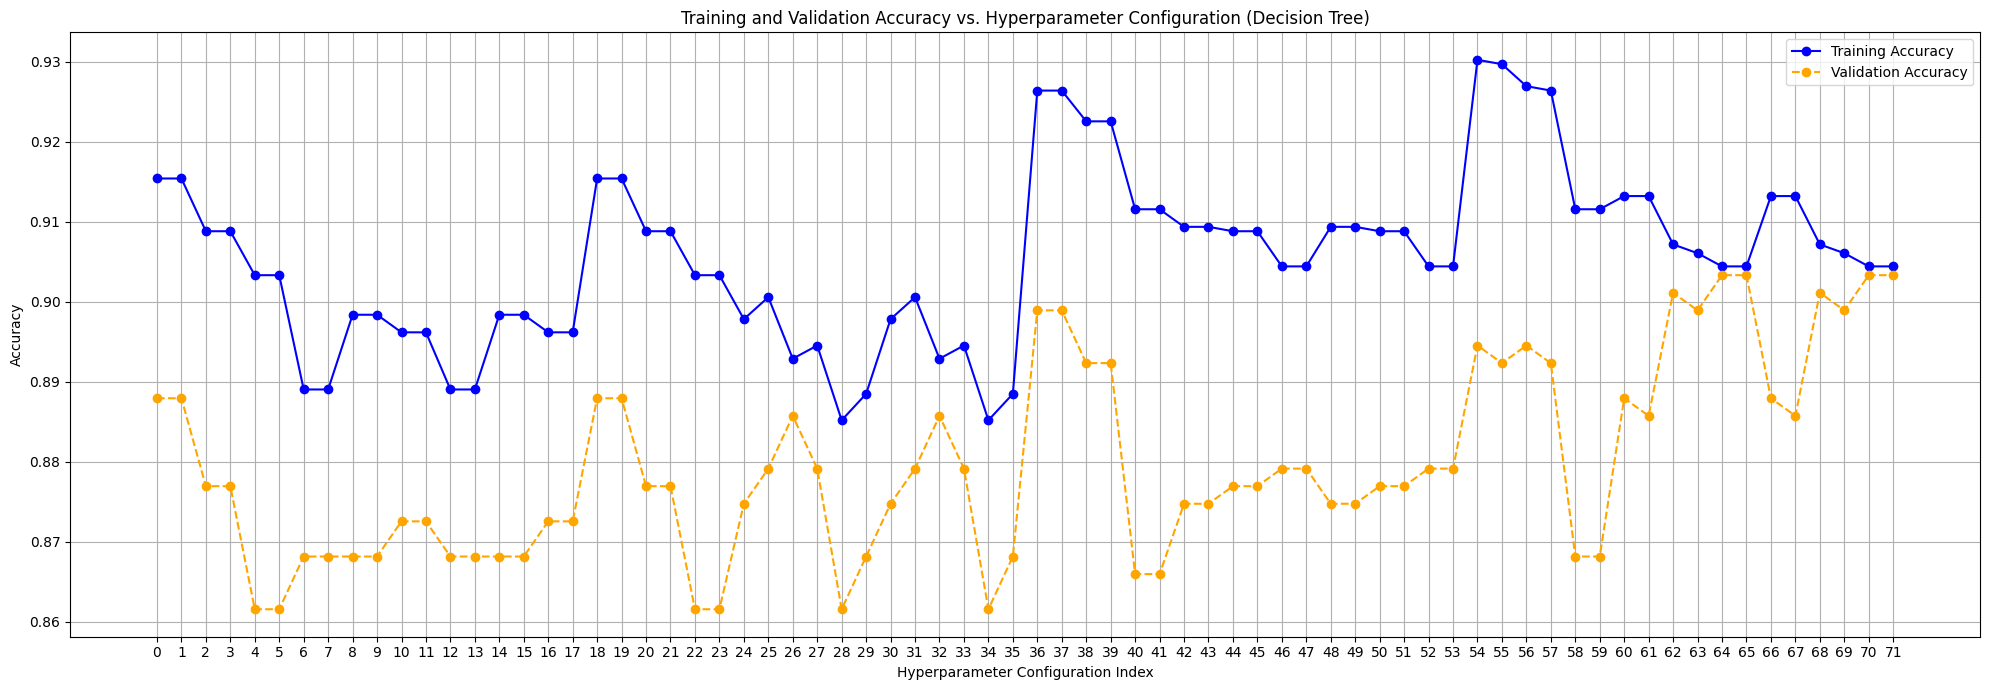


Configuration 0: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30}
   Training Accuracy: 0.9154 		   Validation Accuracy: 0.8879

Configuration 1: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 35}
   Training Accuracy: 0.9154 		   Validation Accuracy: 0.8879

Configuration 2: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 30}
   Training Accuracy: 0.9088 		   Validation Accuracy: 0.8769

Configuration 3: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 35}
   Training Accuracy: 0.9088 		   Validation Accuracy: 0.8769

Configuration 4: {'ccp_alpha': 0.02, 'criterion': 'gini', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 15, 'min_samples_split': 30}
   Training Accuracy: 0.

In [10]:
plot_hyperparameter_results(dt_grid_search, "Decision Tree")

In [11]:
# Get the best model based on the grid search
best_dt_model = dt_grid_search.best_estimator_
dt_grid_search.best_params_

{'ccp_alpha': 0.02,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 15,
 'min_samples_split': 30}

In [12]:
dt_grid_search.best_index_

64

### Training Evaluation

#### Grid search best model validation accuracy

In [13]:
# Get the index of the best configuration
best_config_index = dt_grid_search.best_index_
best_val_accuracy = dt_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 90.33%


### Testing Evaluation


Tuned Decision Tree Performance:

Accuracy: 82.46%
Error Rate: 17.54%
Sensitivity (Recall): 66.67%
Specificity: 91.67%
Precision: 82.35%

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87        72
           1       0.82      0.67      0.74        42

    accuracy                           0.82       114
   macro avg       0.82      0.79      0.80       114
weighted avg       0.82      0.82      0.82       114

Confusion Matrix:


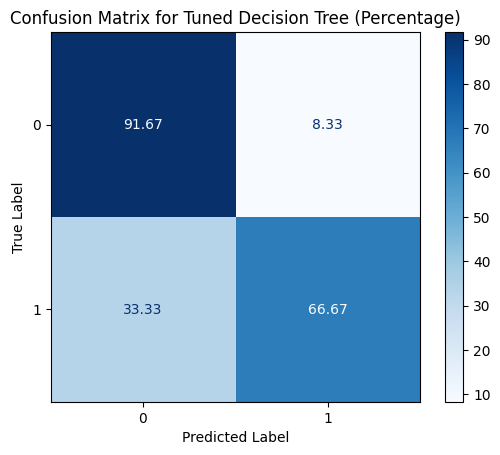

In [14]:
# Predict labels for the test set using the best Decision Tree model
y_test_pred_dt = best_dt_model.predict(X_test)
# Evaluate the model on the test set
evaluate_model(y_test, y_test_pred_dt, "Tuned Decision Tree")

### Plot Decision Tree

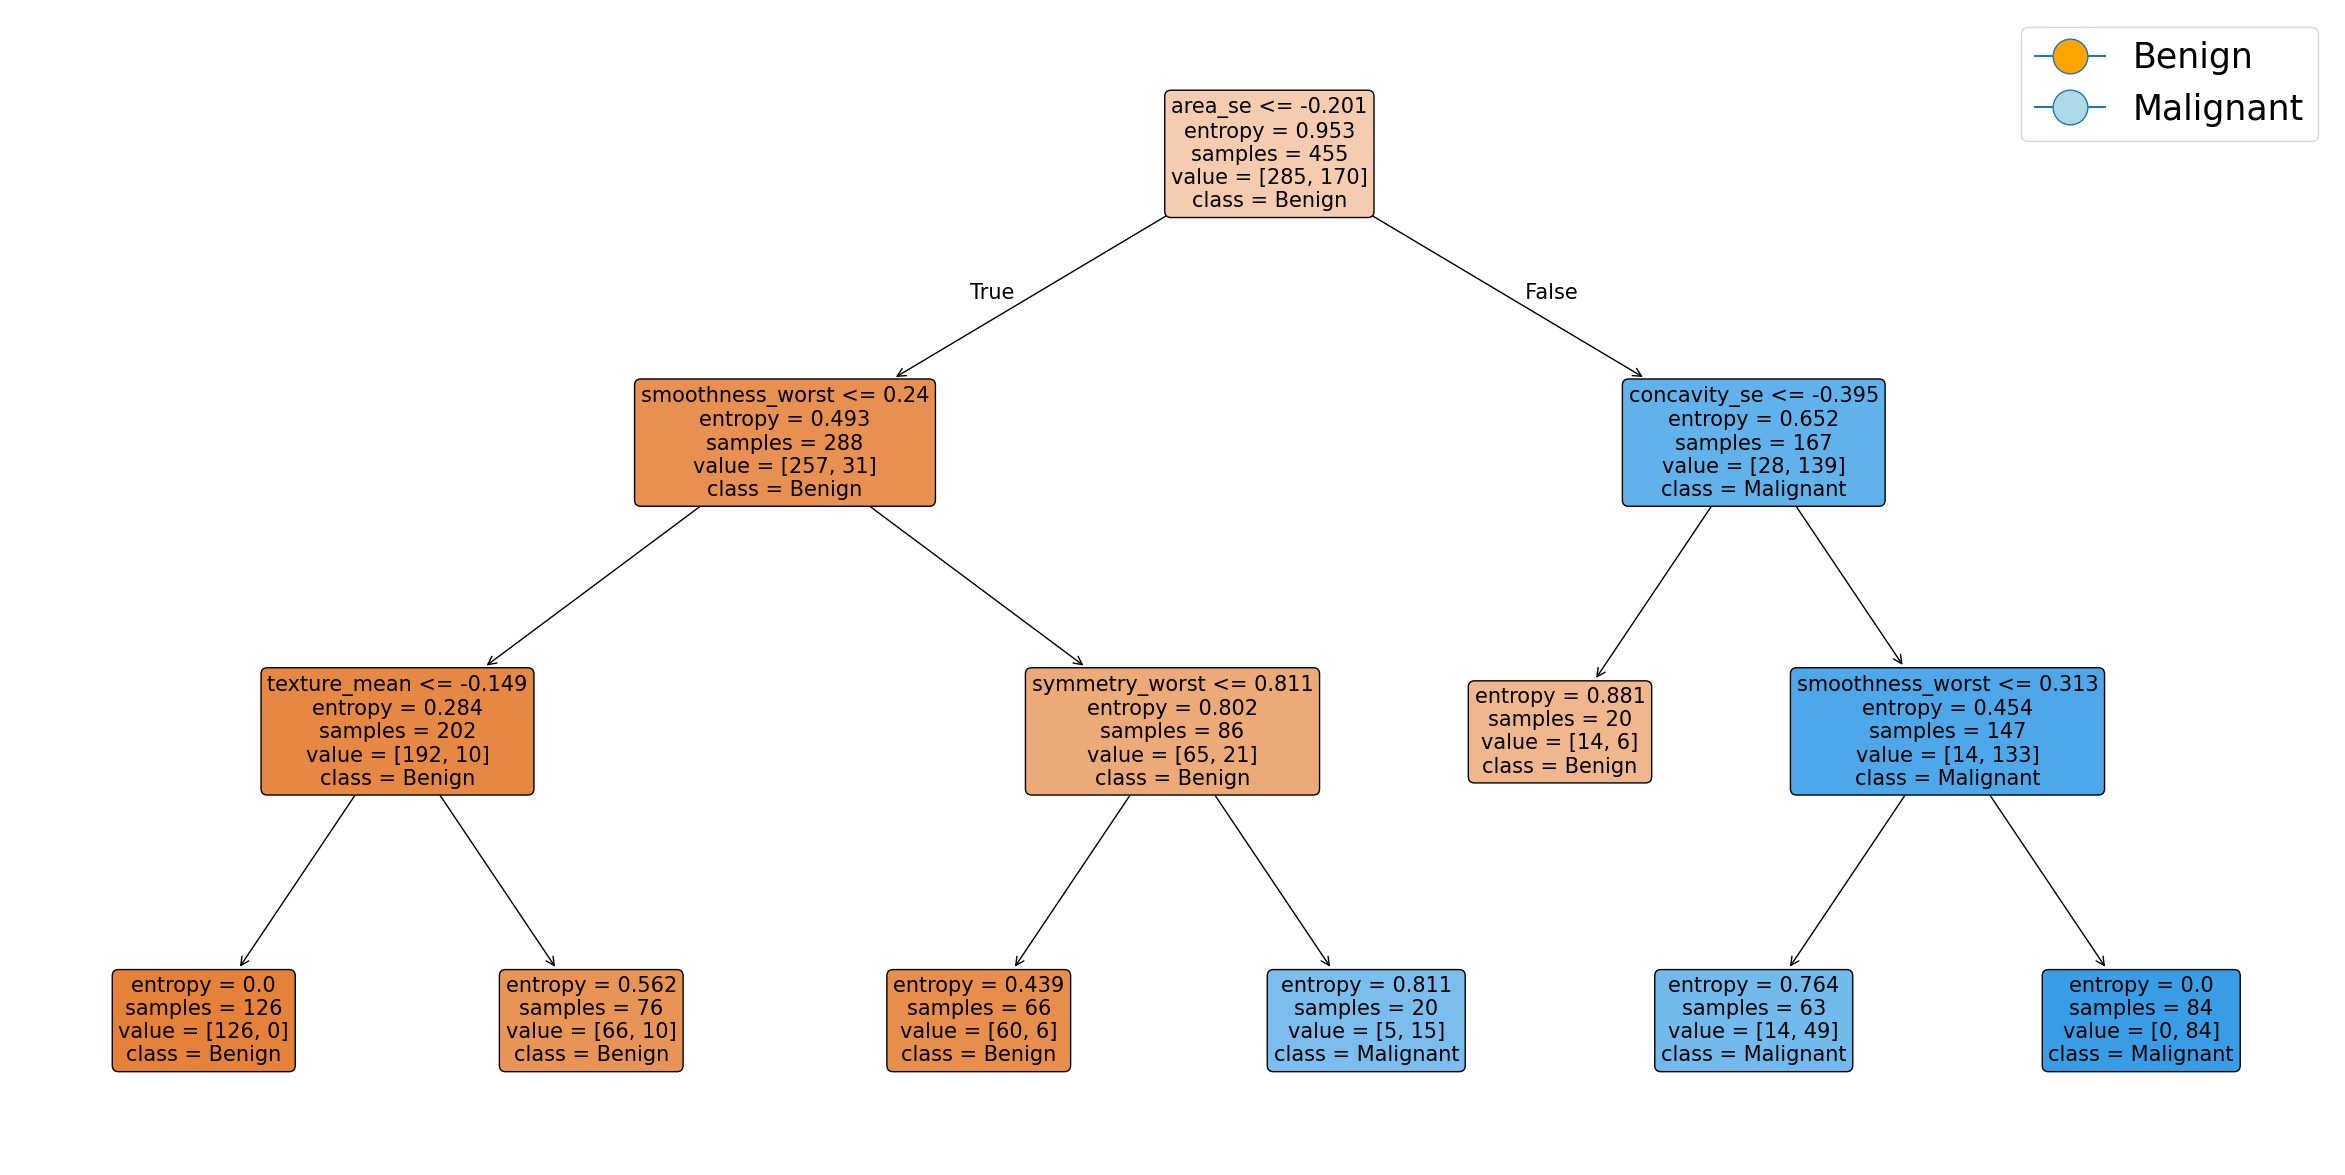

In [15]:
plt.figure(figsize=(30,15))
plot_tree(best_dt_model, filled=True, feature_names=X_train.columns, class_names=["Benign", "Malignant"], rounded=True, fontsize=15)

# Add a legend with colors for the classes
plt.legend(handles=[plt.Line2D([0], [0], marker='o', markerfacecolor=color, markersize=25) for color in ['orange', 'lightblue']], 
           labels=["Benign", "Malignant"], loc="best", fontsize=25)
plt.show()

## KNN Classifier

### Training using grid search

#### Get best hyperparameters using grid search

In [16]:
# Create KNN classifier model
knn_model = KNeighborsClassifier()


In [17]:
# Hyperparameter grid for tuning the Decision Tree
knn_param_grid = {
    # List of possible values for the number of neighbors to consider during classification
    'n_neighbors': [3, 5, 9, 15, 21],

    # List of distance metrics to use when calculating the distance between data points
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

In [18]:
# Set up GridSearchCV to search for the best hyperparameters
knn_grid_search = GridSearchCV(
    estimator=knn_model,                # KNN model
    param_grid=knn_param_grid,          # Hyperparameter grid to search
    scoring='f1_weighted',              # Use F1 weighted score as evaluation metric
    cv=5,                               # 5-fold cross-validation
    return_train_score=True             # Return training scores
)

#### Fit model to get best hyperparameters

In [19]:
knn_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 9, 15, 21]},
             return_train_score=True, scoring='f1_weighted')

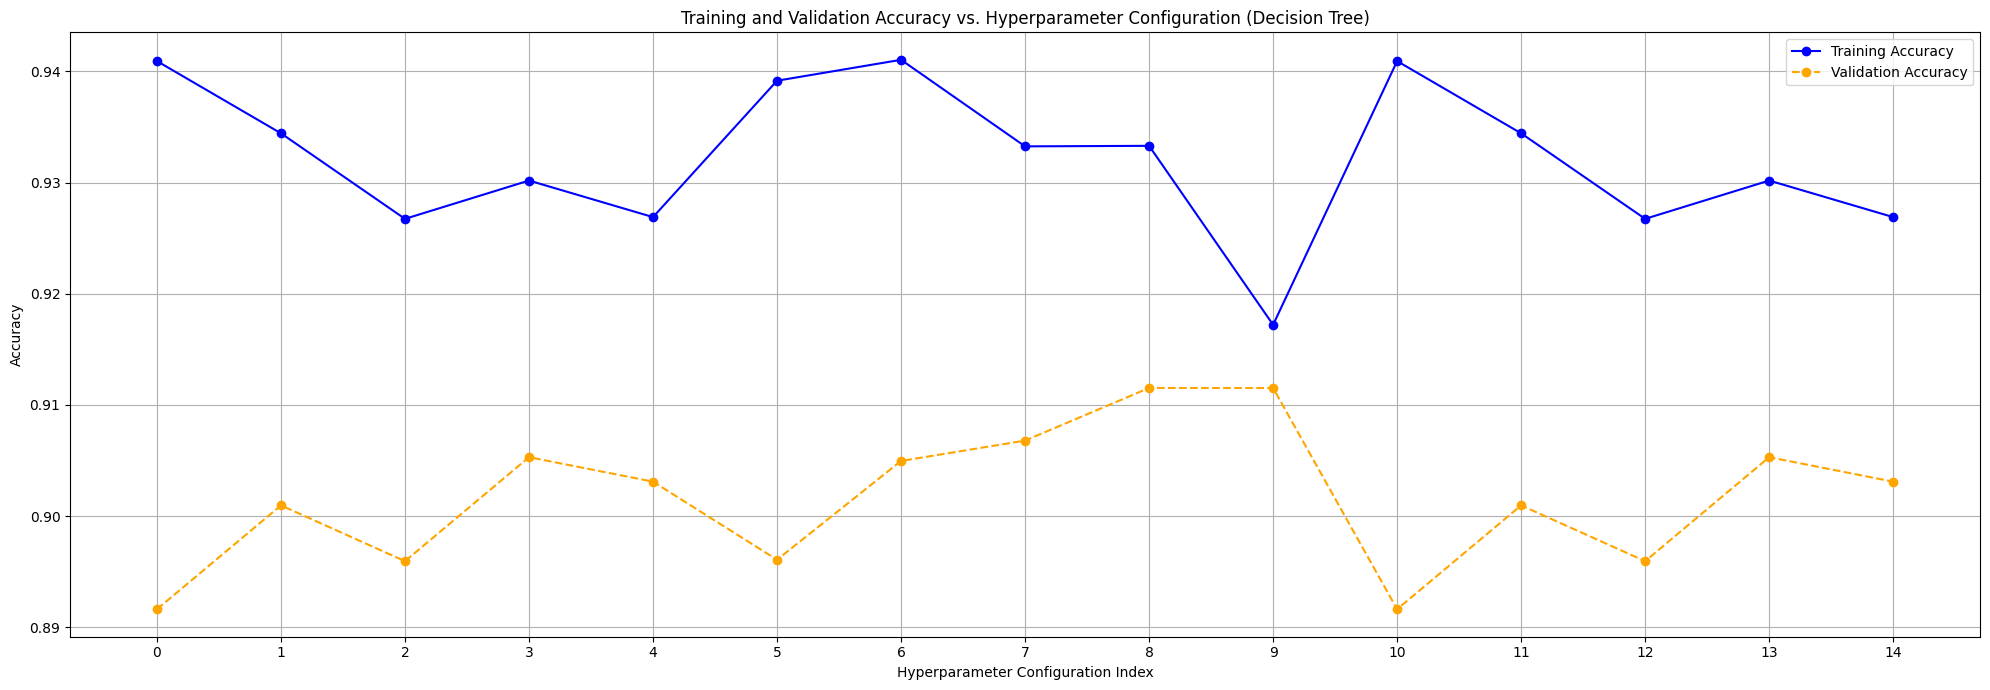


Configuration 0: {'metric': 'euclidean', 'n_neighbors': 3}
   Training Accuracy: 0.9409 		   Validation Accuracy: 0.8916

Configuration 1: {'metric': 'euclidean', 'n_neighbors': 5}
   Training Accuracy: 0.9344 		   Validation Accuracy: 0.9010

Configuration 2: {'metric': 'euclidean', 'n_neighbors': 9}
   Training Accuracy: 0.9267 		   Validation Accuracy: 0.8959

Configuration 3: {'metric': 'euclidean', 'n_neighbors': 15}
   Training Accuracy: 0.9302 		   Validation Accuracy: 0.9053

Configuration 4: {'metric': 'euclidean', 'n_neighbors': 21}
   Training Accuracy: 0.9269 		   Validation Accuracy: 0.9031

Configuration 5: {'metric': 'manhattan', 'n_neighbors': 3}
   Training Accuracy: 0.9392 		   Validation Accuracy: 0.8961

Configuration 6: {'metric': 'manhattan', 'n_neighbors': 5}
   Training Accuracy: 0.9410 		   Validation Accuracy: 0.9050

Configuration 7: {'metric': 'manhattan', 'n_neighbors': 9}
   Training Accuracy: 0.9333 		   Validation Accuracy: 0.9068

Configuration 8: {'me

In [20]:
plot_hyperparameter_results(knn_grid_search, "Decision Tree")

In [21]:
best_knn_model = knn_grid_search.best_estimator_
knn_grid_search.best_params_

{'metric': 'manhattan', 'n_neighbors': 15}

In [22]:
knn_grid_search.best_index_

8

#### Grid search best model validation accuracy

In [23]:
best_knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)

### Training Evaluation

In [24]:
# Get the index of the best configuration
best_config_index = knn_grid_search.best_index_
best_val_accuracy = knn_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 91.15%


### Testing Evaluation


KNN Performance:

Accuracy: 85.09%
Error Rate: 14.91%
Sensitivity (Recall): 66.67%
Specificity: 95.83%
Precision: 90.32%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89        72
           1       0.90      0.67      0.77        42

    accuracy                           0.85       114
   macro avg       0.87      0.81      0.83       114
weighted avg       0.86      0.85      0.84       114

Confusion Matrix:


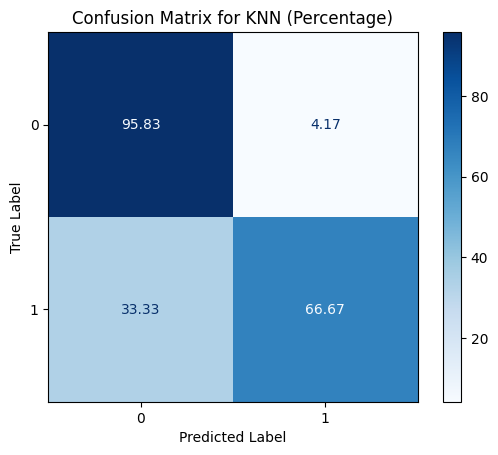

In [25]:
# Predict labels for the test set using the best KNN model
y_test_pred_knn = best_knn_model.predict(X_test)
# Evaluate the performance of the tuned KNN model on the test set
evaluate_model(y_test, y_test_pred_knn, "KNN")

### Training using manual search

#### Split train set to train - validate sets

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

#### Get best k with respect to training and validation accuracy

In [27]:
# Initialize results storage
manual_results = {
    'train_scores': [],
    'val_scores': [],
    'param_combinations': []
}
best_score = 0
best_params = None
best_knn_model = None
best_difference = float('inf')

# Iterate over n_neighbors and metrics
for metric in ['euclidean', 'manhattan']:
    for n in range(3, 30, 2):
        knn = KNeighborsClassifier(n_neighbors=n, weights='uniform', metric=metric)
        knn.fit(X_train, y_train)
        
        # Predict on the training set and validation set
        train_pred = knn.predict(X_train)
        val_pred = knn.predict(X_val)
        
        # Calculate accuracy
        train_accuracy = round(accuracy_score(y_train, train_pred), 5)
        val_accuracy = round(accuracy_score(y_val, val_pred), 5)
        
        # Store the results
        manual_results['train_scores'].append(train_accuracy)
        manual_results['val_scores'].append(val_accuracy)
        manual_results['param_combinations'].append({'n_neighbors': n, 'metric': metric})
        
        # Calculate the difference between training and validation accuracy
        difference = abs(train_accuracy - val_accuracy)
        
        # Update the best model criteria: prioritize high validation accuracy with minimal difference
        if val_accuracy > best_score or (val_accuracy == best_score and difference < best_difference):
            best_score = val_accuracy
            best_difference = difference
            best_params = {'n_neighbors': n, 'metric': metric}
            best_knn_model = knn

# Print the best results
print("Best Parameters:", best_params)
print("Best Validation Accuracy:", best_score)
print("Training vs Validation Accuracy Difference:", best_difference)

Best Parameters: {'n_neighbors': 15, 'metric': 'manhattan'}
Best Validation Accuracy: 0.93407
Training vs Validation Accuracy Difference: 0.0027400000000000757


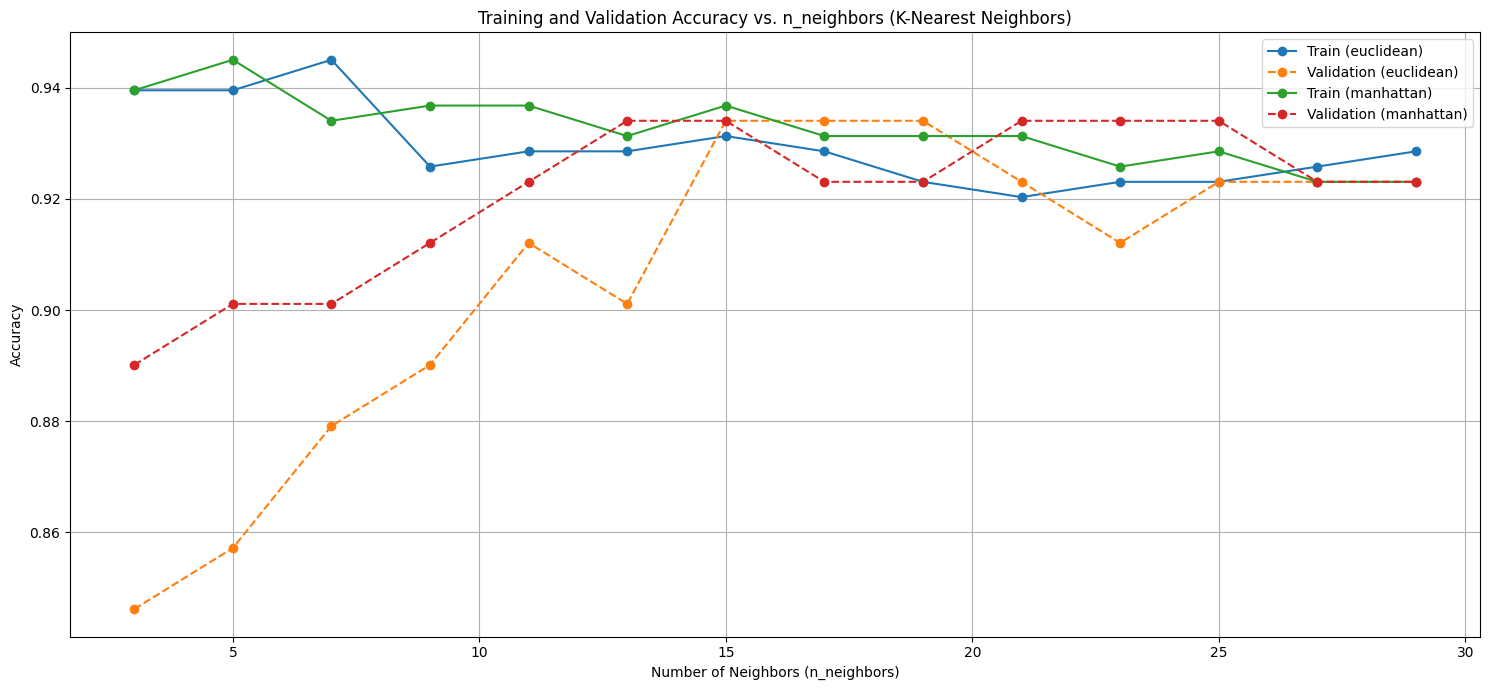

Results for metric: euclidean
  n_neighbors = 3, Training Accuracy: 0.93956, Validation Accuracy: 0.84615
  n_neighbors = 5, Training Accuracy: 0.93956, Validation Accuracy: 0.85714
  n_neighbors = 7, Training Accuracy: 0.94505, Validation Accuracy: 0.87912
  n_neighbors = 9, Training Accuracy: 0.92582, Validation Accuracy: 0.89011
  n_neighbors = 11, Training Accuracy: 0.92857, Validation Accuracy: 0.91209
  n_neighbors = 13, Training Accuracy: 0.92857, Validation Accuracy: 0.90110
  n_neighbors = 15, Training Accuracy: 0.93132, Validation Accuracy: 0.93407
  n_neighbors = 17, Training Accuracy: 0.92857, Validation Accuracy: 0.93407
  n_neighbors = 19, Training Accuracy: 0.92308, Validation Accuracy: 0.93407
  n_neighbors = 21, Training Accuracy: 0.92033, Validation Accuracy: 0.92308
  n_neighbors = 23, Training Accuracy: 0.92308, Validation Accuracy: 0.91209
  n_neighbors = 25, Training Accuracy: 0.92308, Validation Accuracy: 0.92308
  n_neighbors = 27, Training Accuracy: 0.92582, Va

In [28]:
def plot_manual_results_with_metric(manual_results, model_name):
    # Extract results
    train_scores = manual_results['train_scores']
    val_scores = manual_results['val_scores']
    param_combinations = manual_results['param_combinations']  # List of dictionaries with n_neighbors and metric

    # Separate results by metric
    metrics = list(set([param['metric'] for param in param_combinations]))
    plt.figure(figsize=(15, 7))

    for metric in metrics:
        # Filter results for the current metric
        indices = [i for i, param in enumerate(param_combinations) if param['metric'] == metric]
        n_neighbors = [param_combinations[i]['n_neighbors'] for i in indices]
        train_metric_scores = [train_scores[i] for i in indices]
        val_metric_scores = [val_scores[i] for i in indices]

        # Plot training and validation scores for the current metric
        plt.plot(n_neighbors, train_metric_scores, marker='o', linestyle='-', label=f'Train ({metric})')
        plt.plot(n_neighbors, val_metric_scores, marker='o', linestyle='--', label=f'Validation ({metric})')

    # Add labels, legend, and grid
    plt.xlabel('Number of Neighbors (n_neighbors)')
    plt.ylabel('Accuracy')
    plt.title(f'Training and Validation Accuracy vs. n_neighbors ({model_name})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print detailed results for each metric
    for metric in metrics:
        print(f"Results for metric: {metric}")
        for i, param in enumerate(param_combinations):
            if param['metric'] == metric:
                print(f"  n_neighbors = {param['n_neighbors']}, Training Accuracy: {train_scores[i]:.5f}, Validation Accuracy: {val_scores[i]:.5f}")
        print("-" * 50)

# Example usage:
plot_manual_results_with_metric(manual_results, model_name="K-Nearest Neighbors")

#### fit model using best parameter

In [29]:
# Extract the best parameters
best_n_neighbors, best_metric = best_params['n_neighbors'], best_params['metric']

In [30]:
# Initialize the KNN model with the best parameters
best_manual_knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors, weights='uniform', metric=best_metric)

In [31]:
# Fit the model on the entire training set
best_manual_knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=15)

#### Training Evaluation


KNN Performance:

Accuracy: 93.41%
Error Rate: 6.59%
Sensitivity (Recall): 84.85%
Specificity: 98.28%
Precision: 96.55%

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95        58
           1       0.97      0.85      0.90        33

    accuracy                           0.93        91
   macro avg       0.94      0.92      0.93        91
weighted avg       0.94      0.93      0.93        91

Confusion Matrix:


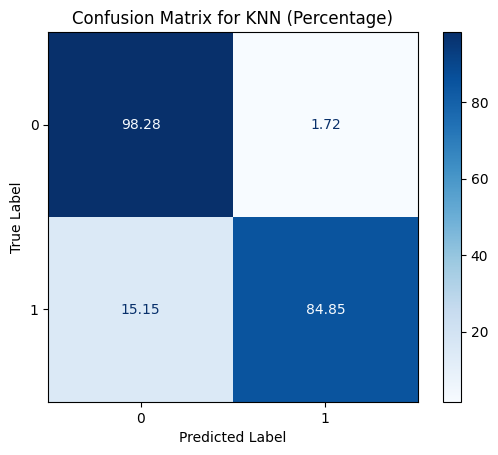

In [32]:
y_val_pred_knn = best_manual_knn_model.predict(X_val)
evaluate_model(y_val, y_val_pred_knn, "KNN")

#### Test Evaluation


KNN Performance:

Accuracy: 86.84%
Error Rate: 13.16%
Sensitivity (Recall): 73.81%
Specificity: 94.44%
Precision: 88.57%

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90        72
           1       0.89      0.74      0.81        42

    accuracy                           0.87       114
   macro avg       0.87      0.84      0.85       114
weighted avg       0.87      0.87      0.87       114

Confusion Matrix:


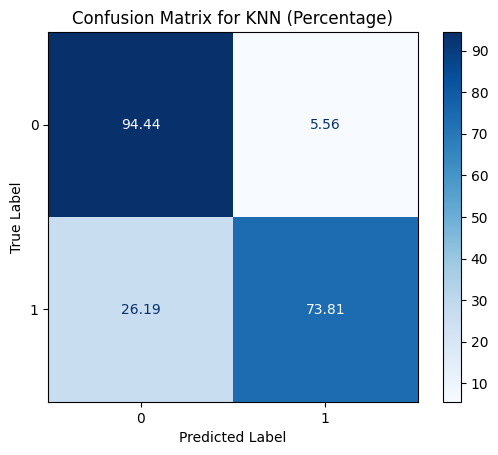

In [33]:
y_test_pred_knn = best_manual_knn_model.predict(X_test)
evaluate_model(y_test, y_test_pred_knn, "KNN")

## Naïve Bayes Classifier

### Split data into Train, Validation, and Test Sets

In [34]:
X = df.drop('diagnosis', axis = 1)
y = df['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

Split data into training (80%), testing (20%)

Then training into training (80%), validation (20%)

64% training - 16% validation - 20% testing

### Intialize model

In [35]:
nb_model = GaussianNB()

#### Fit model

In [36]:
nb_model.fit(X_train, y_train)

GaussianNB()

### Training Evaluation


Naïve Bayes Performance:

Accuracy: 91.21%
Error Rate: 8.79%
Sensitivity (Recall): 90.91%
Specificity: 91.38%
Precision: 85.71%

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.91      0.93        58
           1       0.86      0.91      0.88        33

    accuracy                           0.91        91
   macro avg       0.90      0.91      0.91        91
weighted avg       0.91      0.91      0.91        91

Confusion Matrix:


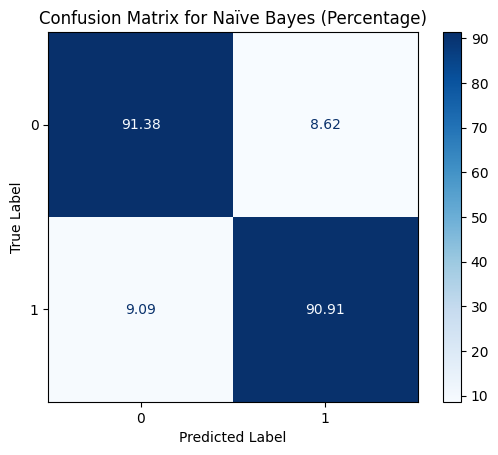

In [37]:
y_val_pred = nb_model.predict(X_val)
evaluate_model(y_val, y_val_pred, "Naïve Bayes")

### Testing Evaluation


Naïve Bayes Performance:

Accuracy: 87.72%
Error Rate: 12.28%
Sensitivity (Recall): 80.95%
Specificity: 91.67%
Precision: 85.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.92      0.90        72
           1       0.85      0.81      0.83        42

    accuracy                           0.88       114
   macro avg       0.87      0.86      0.87       114
weighted avg       0.88      0.88      0.88       114

Confusion Matrix:


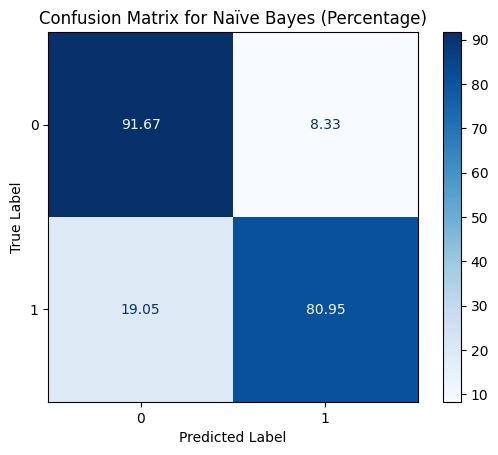

In [38]:
y_test_pred_nb = nb_model.predict(X_test)
evaluate_model(y_test, y_test_pred_nb, "Naïve Bayes")

## Multi‐Layer Perceptron

### Intialize model

In [39]:
mlp_model = MLPClassifier()

#### Get best hyperparameters using grid search

In [40]:
mlp_param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10, 10)],  # Smaller networks
    'activation': ['relu'],  # Stick with ReLU for simpler decision boundaries
    'solver': ['adam'],
    'max_iter': [200],  # Reduce iterations
    'alpha': [0.01, 0.1],  # Stronger regularization
    'batch_size': [32, 64],  # Explicit batch sizes for better regularization
    'early_stopping': [True],  # Add early stopping
    'validation_fraction': [0.2]  # Set aside validation data
}

In [41]:
# Set up GridSearchCV to tune hyperparameters with 5-fold cross-validation
mlp_grid_search = GridSearchCV(
    estimator=mlp_model,
    param_grid=mlp_param_grid,
    scoring='f1_weighted',  # Evaluation metric
    cv=5,  # 5-fold cross-validation
    return_train_score=True,
    n_jobs=-1  # Parallelize the process if you have multiple CPU cores
)

#### Fit model to get best hyperparameters

In [42]:
mlp_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.01, 0.1],
                         'batch_size': [32, 64], 'early_stopping': [True],
                         'hidden_layer_sizes': [(10,), (20,), (10, 10)],
                         'max_iter': [200], 'solver': ['adam'],
                         'validation_fraction': [0.2]},
             return_train_score=True, scoring='f1_weighted')

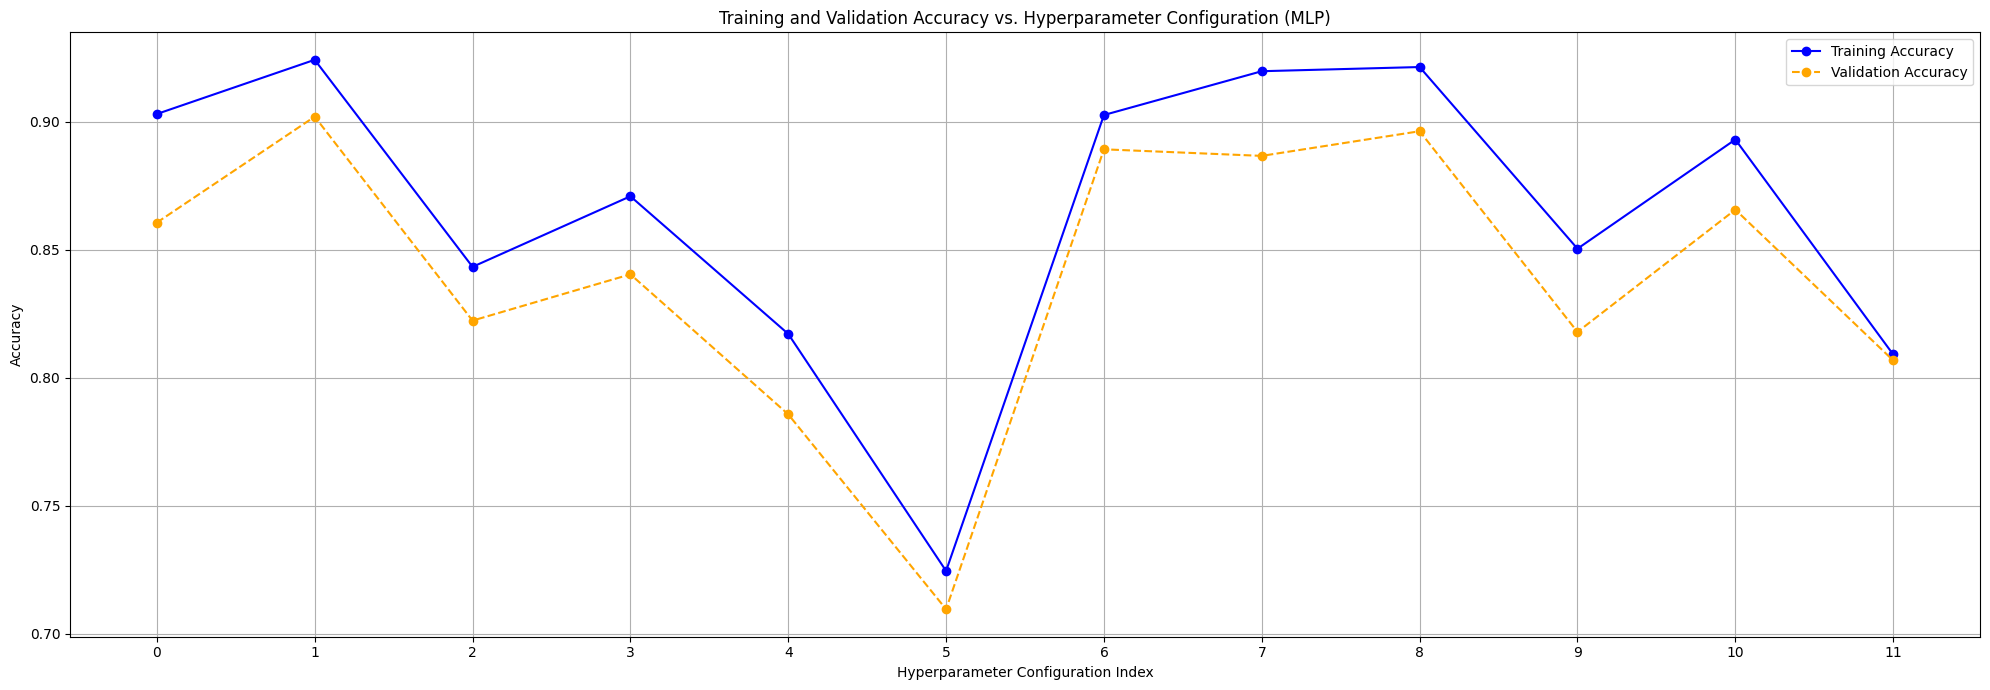


Configuration 0: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (10,), 'max_iter': 200, 'solver': 'adam', 'validation_fraction': 0.2}
   Training Accuracy: 0.9030 		   Validation Accuracy: 0.8606

Configuration 1: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (20,), 'max_iter': 200, 'solver': 'adam', 'validation_fraction': 0.2}
   Training Accuracy: 0.9242 		   Validation Accuracy: 0.9020

Configuration 2: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 32, 'early_stopping': True, 'hidden_layer_sizes': (10, 10), 'max_iter': 200, 'solver': 'adam', 'validation_fraction': 0.2}
   Training Accuracy: 0.8433 		   Validation Accuracy: 0.8223

Configuration 3: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 64, 'early_stopping': True, 'hidden_layer_sizes': (10,), 'max_iter': 200, 'solver': 'adam', 'validation_fraction': 0.2}
   Training Accuracy: 0.8709 		   Validation Accura

In [43]:
plot_hyperparameter_results(mlp_grid_search, "MLP")

In [44]:
# Get the best model based on the grid search
best_mlp_model = mlp_grid_search.best_estimator_
mlp_grid_search.best_params_

{'activation': 'relu',
 'alpha': 0.01,
 'batch_size': 32,
 'early_stopping': True,
 'hidden_layer_sizes': (20,),
 'max_iter': 200,
 'solver': 'adam',
 'validation_fraction': 0.2}

In [45]:
mlp_grid_search.best_index_

1

### Training Evaluation

#### Grid search best model validation accuracy

In [46]:
# Get the index of the best configuration
best_config_index = mlp_grid_search.best_index_
best_val_accuracy = mlp_grid_search.cv_results_['mean_test_score'][best_config_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 90.20%


### Testing Evaluation


MLP Performance:

Accuracy: 83.33%
Error Rate: 16.67%
Sensitivity (Recall): 64.29%
Specificity: 94.44%
Precision: 87.10%

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.94      0.88        72
           1       0.87      0.64      0.74        42

    accuracy                           0.83       114
   macro avg       0.85      0.79      0.81       114
weighted avg       0.84      0.83      0.83       114

Confusion Matrix:


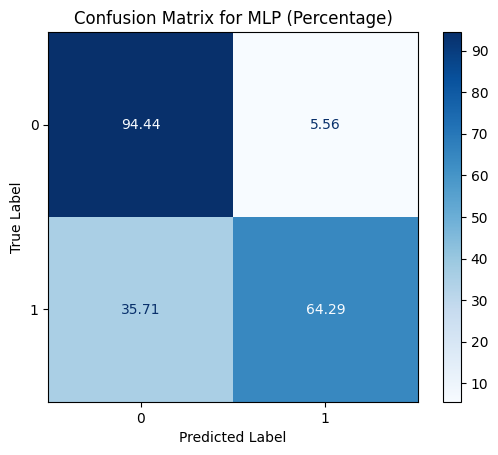

In [47]:
y_test_pred_MLP = best_mlp_model.predict(X_test)
evaluate_model(y_test, y_test_pred_MLP, "MLP")

In [48]:
# Grids hyperparameter
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 0.01, 0.001]
}

In [49]:
# Set up GridSearchCV for SVM
svm_model = SVC(random_state=42)
svm_grid_search = GridSearchCV(estimator=svm_model, param_grid=svm_param_grid, scoring='f1_weighted', cv=5, return_train_score=True)

In [50]:
svm_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.1, 0.01, 0.001],
                         'kernel': ['linear', 'rbf']},
             return_train_score=True, scoring='f1_weighted')

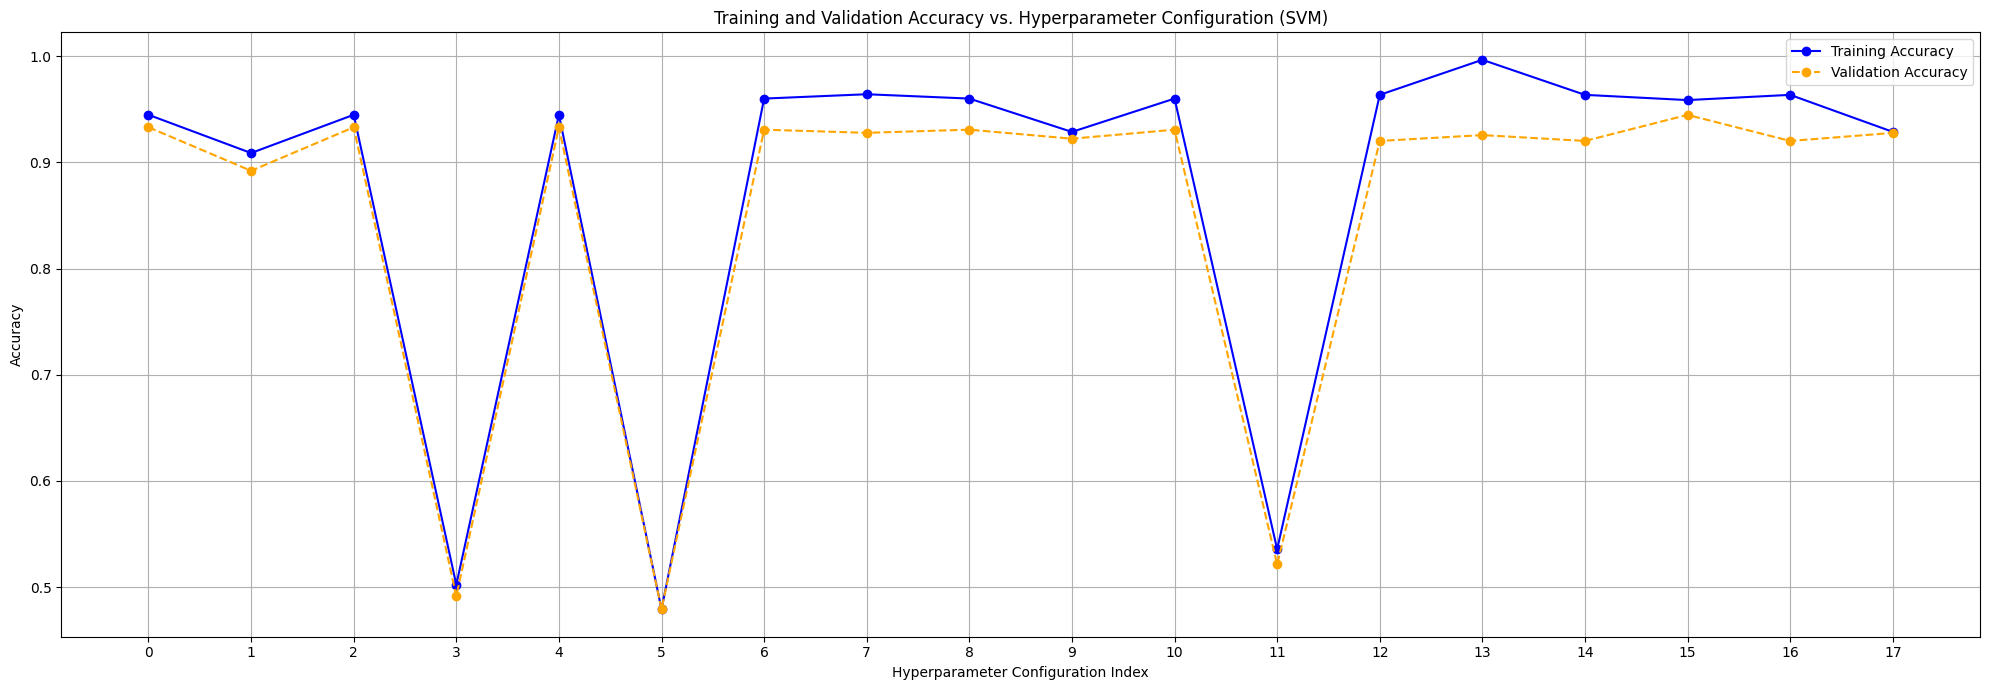


Configuration 0: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
   Training Accuracy: 0.9448 		   Validation Accuracy: 0.9330

Configuration 1: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
   Training Accuracy: 0.9088 		   Validation Accuracy: 0.8920

Configuration 2: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
   Training Accuracy: 0.9448 		   Validation Accuracy: 0.9330

Configuration 3: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
   Training Accuracy: 0.5021 		   Validation Accuracy: 0.4914

Configuration 4: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
   Training Accuracy: 0.9448 		   Validation Accuracy: 0.9330

Configuration 5: {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
   Training Accuracy: 0.4791 		   Validation Accuracy: 0.4791

Configuration 6: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
   Training Accuracy: 0.9600 		   Validation Accuracy: 0.9308

Configuration 7: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
   Training Accuracy: 0.9641 		   Validation Accuracy: 0.9278

Configura

In [51]:
plot_hyperparameter_results(svm_grid_search, "SVM")

In [52]:
best_svm_model = svm_grid_search.best_estimator_


In [53]:
svm_grid_search.best_params_
svm_grid_search.best_index_


15

In [54]:
# Get the index of the best configuration
best_config2_index = svm_grid_search.best_index_
best_val2_accuracy = svm_grid_search.cv_results_['mean_test_score'][best_config2_index]

# Print the best configuration and its corresponding accuracy
print(f"Validation accuracy for best configuration: {best_val2_accuracy * 100:.2f}%")

Validation accuracy for best configuration: 94.47%



SVM Performance:

Accuracy: 93.86%
Error Rate: 6.14%
Sensitivity (Recall): 83.33%
Specificity: 100.00%
Precision: 100.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        72
           1       1.00      0.83      0.91        42

    accuracy                           0.94       114
   macro avg       0.96      0.92      0.93       114
weighted avg       0.94      0.94      0.94       114

Confusion Matrix:


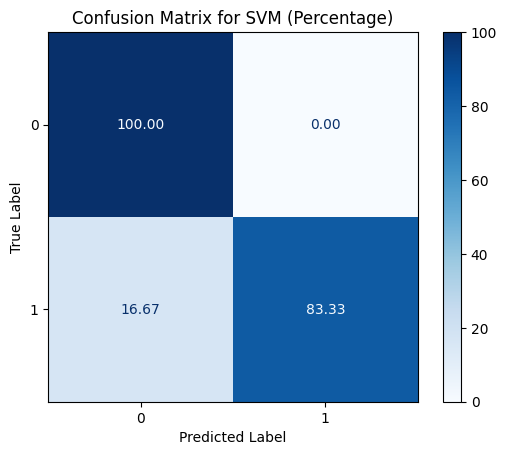

In [55]:
y_test_pred_SVM = best_svm_model.predict(X_test)
evaluate_model(y_test, y_test_pred_SVM, "SVM")

## Models Comparisions

In [56]:
# Extract weighted average metrics
metrics = ["precision", "recall", "f1-score"]
x_labels = ["Precision", "Recall", "F1-Score"]

In [57]:
# To plot histogram
x = np.arange(len(metrics))
width = 0.15

### Validation Weighted Metrics

In [58]:
# Classification reports for testing
report_test_svm = classification_report(y_test, y_test_pred_SVM, output_dict=True)
report_test_nb = classification_report(y_test, y_test_pred_nb, output_dict=True)
report_test_knn = classification_report(y_test, y_test_pred_knn, output_dict=True)
report_test_dt = classification_report(y_test, y_test_pred_dt, output_dict=True)
report_test_mlp = classification_report(y_test, y_test_pred_MLP, output_dict=True) 


In [59]:
# Testing metrics
svm_test_metrics = [report_test_svm["weighted avg"][metric] for metric in metrics]
nb_test_metrics = [report_test_nb["weighted avg"][metric] for metric in metrics]
knn_test_metrics = [report_test_knn["weighted avg"][metric] for metric in metrics]
dt_test_metrics = [report_test_dt["weighted avg"][metric] for metric in metrics]
mlp_test_metrics = [report_test_mlp["weighted avg"][metric] for metric in metrics]  # Extracted MLP metrics

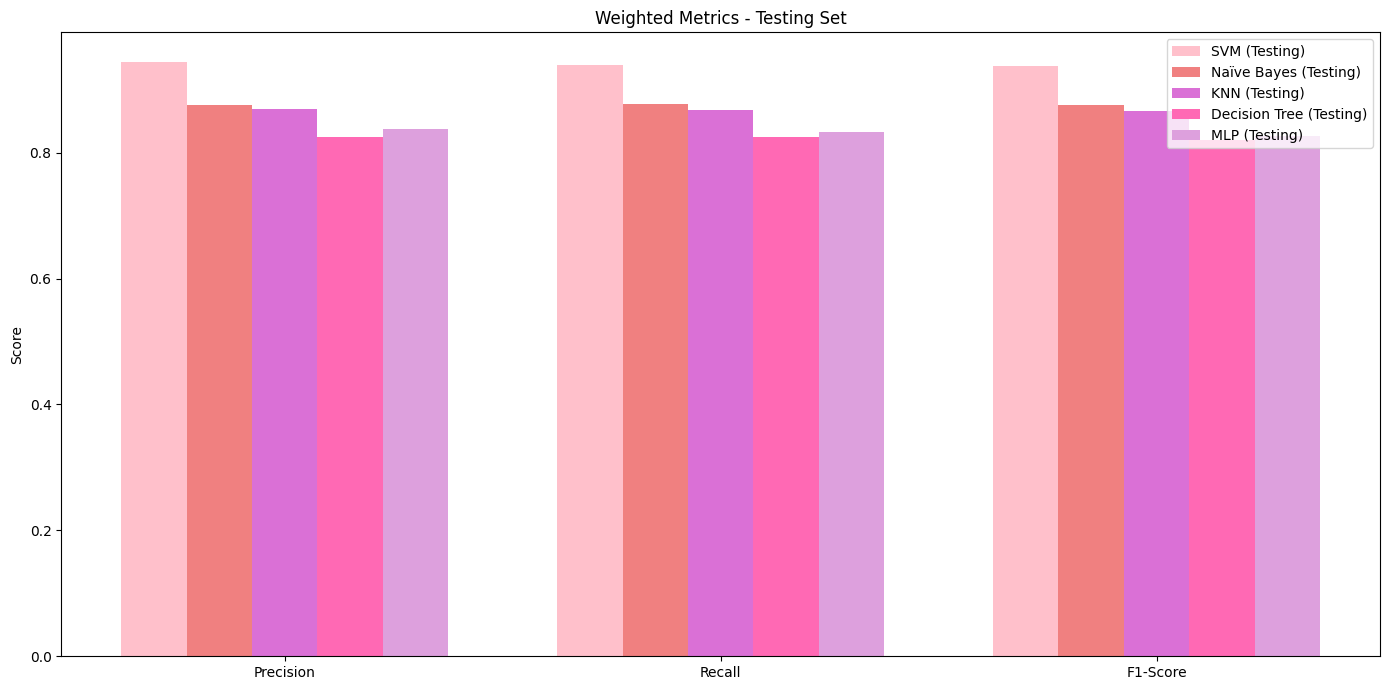

In [60]:
# Plotting
plt.figure(figsize=(14, 7))
x_offset = [-2, -1, 0, 1, 2]  # Adjusted x offsets for 5 models
colors = ["pink", "lightcoral", "orchid", "hotpink", "plum"]   # Added color for MLP
labels = ["SVM (Testing)", "Naïve Bayes (Testing)", "KNN (Testing)", "Decision Tree (Testing)", "MLP (Testing)"]
all_metrics = [svm_test_metrics, nb_test_metrics, knn_test_metrics, dt_test_metrics, mlp_test_metrics]

# Bar plot for each model
for offset, metrics, color, label in zip(x_offset, all_metrics, colors, labels):
    plt.bar(x + offset * width, metrics, width, label=label, color=color)

plt.ylabel("Score")
plt.title("Weighted Metrics - Testing Set")
plt.xticks(x, x_labels)
plt.legend(loc="best")
plt.tight_layout()
plt.show()

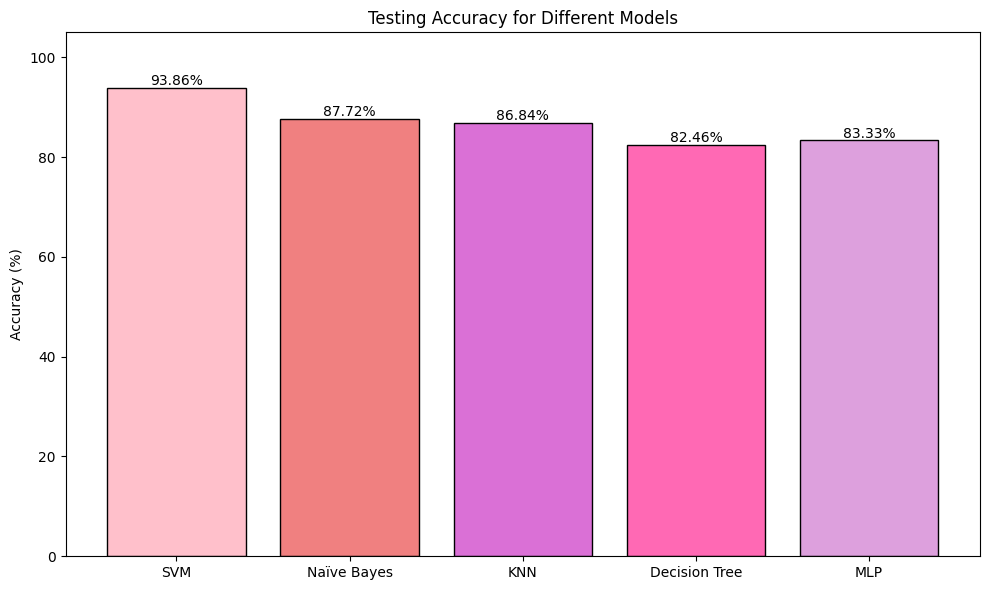

In [66]:
svm_test_accuracy = report_test_svm["accuracy"]
nb_test_accuracy = report_test_nb["accuracy"]
knn_test_accuracy = report_test_knn["accuracy"]
dt_test_accuracy = report_test_dt["accuracy"]
mlp_test_accuracy = report_test_mlp["accuracy"]
# Plotting
plt.figure(figsize=(10, 6))
models = ["SVM", "Naïve Bayes", "KNN", "Decision Tree", "MLP"]
accuracies = [
    svm_test_accuracy,
    nb_test_accuracy,
    knn_test_accuracy,
    dt_test_accuracy,
    mlp_test_accuracy,
]

accuracies = [acc * 100 for acc in accuracies]  # Convert to percentages

colors = ["pink", "lightcoral", "orchid", "hotpink", "plum"]  # Girly colors

# Bar plot for testing accuracies
plt.bar(models, accuracies, color=colors, edgecolor="black")

# Annotate bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.5, f"{acc:.2f}%", ha="center", fontsize=10, color="black")

plt.ylabel("Accuracy (%)")
plt.title("Testing Accuracy for Different Models")
plt.ylim(0, 105)  # Set y-axis limit to include annotations
plt.tight_layout()
plt.show()

# Save Models

In [ ]:
import joblib
joblib.dump(best_dt_model, 'decision_tree_model.pkl')
joblib.dump(nb_model, 'naive_bayes_model.pkl')
joblib.dump(best_knn_model, 'knn_model.pkl')
joblib.dump(best_mlp_model, 'mlp_model.pkl')
joblib.dump(best_svm_model, 'svm_model.pkl')